In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os
import json

import matplotlib.pyplot as plt


In [2]:
from tensorflow import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.models import Sequential
from keras.regularizers import l2
from keras.constraints import maxnorm

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
#Import Data
x_img = 108
y_img = 192
#Channels=1 for BW, 3 for Color
channels = 1

folder = 'tighter_frames'

inputShape = (x_img,y_img,channels)

fileList_train = []
x_train = np.array([])
x_train = x_train.reshape(0,x_img,y_img,channels)
y_train = np.array([])

#Import the dictionary of directors
with open('Data/truthVector.json',mode='r') as fp:
    truthDict = json.load(fp)

    
#Import the training data
for file in os.listdir(folder + '/blackwhite'):
    if file=='Test' or file=='Valid':
        continue
    #print(file)
    #Load the numpy file and reshape to (#examples,xsize,ysize,#channels)    
    mov = np.load(folder + '/blackwhite/'+file)
    frames = np.shape(mov)[1]
    mov = mov.T
    mov = mov.reshape(np.shape(mov)[0],x_img,y_img,channels)
    
    #Record the filename and starting index
    fileList_train.append((file[:-7],np.shape(x_train)[0]))

    #Append the movie and director
    x_train = np.append(x_train,mov,axis=0)
    yvec = truthDict[file[:-7] + '.mp4'] * np.ones(frames)
    y_train = np.append(y_train,yvec)


# Import the validation data
x_valid = np.array([])
x_valid = x_valid.reshape(0,x_img,y_img,channels)
y_valid = np.array([])

for file in os.listdir(folder + '/blackwhite/Valid'):
    mov = np.load(folder + '/blackwhite/Valid/'+file)
    frames = np.shape(mov)[1]
    mov = mov.T
    mov = mov.reshape(frames,x_img,y_img,channels)
    
    #Append the movie and director
    x_valid = np.append(x_valid,mov,axis=0)
    yvec = truthDict[file[:-7]+'.mp4'] * np.ones(frames)
    y_valid = np.append(y_valid,yvec)

    
# Import the test Data    
fileList_test = []
x_test = np.array([])
x_test = x_test.reshape(0,x_img,y_img,channels)
y_test = np.array([])

for file in os.listdir(folder + '/blackwhite/Test'):
    mov = np.load(folder + '/blackwhite/Test/'+file)
    frames = np.shape(mov)[1]
    mov = mov.T
    mov = mov.reshape(frames,x_img,y_img,channels)
    
    #Record the filename and starting index
    fileList_test.append((file[:-7],np.shape(x_train)[0]))
    
    #Append the movie and director
    x_test = np.append(x_test,mov,axis=0)
    yvec = truthDict[file[:-7] + '.mp4'] * np.ones(frames)
    y_test = np.append(y_test,yvec)
    
    
print(np.shape(x_train))
# Shape should be (2513,144,256,#Channels)

#Normalize the input
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_valid /= 255
x_test /= 255


numClasses = int(np.max(y_train) + 1)
y_train = keras.utils.to_categorical(y_train,numClasses)
y_valid = keras.utils.to_categorical(y_valid,numClasses)
y_test = keras.utils.to_categorical(y_test,numClasses)

print(numClasses)
# ^Should be # of directors (6)
print(np.max(x_train))
print(np.max(x_valid))
print(np.max(x_test))
# ^Should be 1

(1890, 108, 192, 1)
6
1.0
1.0
1.0


In [4]:
print(np.shape(x_train))
print(np.shape(y_train))

print(np.shape(x_valid))
print(np.shape(y_valid))

print(np.shape(x_test))
print(np.shape(y_test))

print(np.max(x_valid))
print(np.max(x_test))

(1890, 108, 192, 1)
(1890, 6)
(646, 108, 192, 1)
(646, 6)
(338, 108, 192, 1)
(338, 6)
1.0
1.0


In [ ]:
# #Define CNN
# model = Sequential()
# model.add(Conv2D(5, kernel_size=(3,3),strides=(1,1),padding='same', activation='relu',
#                  input_shape = inputShape))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# model.add(Conv2D(5, kernel_size=(3,3),strides=(1,1),padding='same', activation='relu'
#                  ))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# model.add(Conv2D(5, kernel_size=(3,3),strides=(1,1),padding='same', activation='relu'
#                  ))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# model.add(Conv2D(5, kernel_size=(3,3),strides=(1,1),padding='same', activation='relu'
#                  ))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# #Fully Connected Layer
# model.add(Flatten())
# model.add(Dense(200, activation='relu'))
# model.add(Dense(numClasses, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])
# model.summary()

In [11]:
#Define CNN
#Number of Filters
K = 10
#L2 regularization parameter
lam = 1
#Number of Neurons
N = 100
#Dropout Rate
r = 0.2

model = Sequential()
model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same', use_bias=False,  
                 kernel_regularizer=l2(lam), input_shape = inputShape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(r))
model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same', use_bias=False, 
                 kernel_regularizer=l2(lam)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(r))

model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same', use_bias=False,  
                 kernel_regularizer=l2(lam)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(r))
model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same', use_bias=False, 
                 kernel_regularizer=l2(lam)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#Fully Connected Layer
model.add(Dropout(r))
model.add(Flatten())
model.add(Dense(N, kernel_regularizer=l2(lam),use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(numClasses, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 108, 192, 10)      90        
_________________________________________________________________
batch_normalization_11 (Batc (None, 108, 192, 10)      40        
_________________________________________________________________
activation_11 (Activation)   (None, 108, 192, 10)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 108, 192, 10)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 108, 192, 10)      900       
_________________________________________________________________
batch_normalization_12 (Batc (None, 108, 192, 10)      40        
_________________________________________________________________
activation_12 (Activation)   (None, 108, 192, 10)     

In [ ]:
# #Define CNN
# #Number of Filters
# K = 10
# #L2 regularization parameter
# lam = .01
# #Number of Neurons
# N = 50
# #Dropout Rate
# r = 0.2

# model = Sequential()
# model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same',  
#                  kernel_constraint=maxnorm(3), input_shape = inputShape))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(r))
# model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same', 
#                  kernel_constraint=maxnorm(3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(r))

# model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same',   
#                  kernel_constraint=maxnorm(3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(r))
# model.add(Conv2D(K, kernel_size=(3,3),strides=(1,1),padding='same',  
#                  kernel_constraint=maxnorm(3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# #Fully Connected Layer
# model.add(Dropout(r))
# model.add(Flatten())
# model.add(Dense(N, kernel_constraint=maxnorm(3)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dense(numClasses, activation='softmax'))

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
# model.summary()

Train on 2028 samples, validate on 508 samples
Epoch 1/5
2028/2028 [==============================] - 144s 71ms/step - loss: 6.4487 - accuracy: 0.3935 - val_loss: 5.0271 - val_accuracy: 0.4429
Epoch 2/5
2028/2028 [==============================] - 154s 76ms/step - loss: 6.0270 - accuracy: 0.4103 - val_loss: 6.4966 - val_accuracy: 0.1594
Epoch 3/5
2028/2028 [==============================] - 149s 74ms/step - loss: 5.6338 - accuracy: 0.4186 - val_loss: 6.0883 - val_accuracy: 0.1870
Epoch 4/5
2028/2028 [==============================] - 150s 74ms/step - loss: 5.5803 - accuracy: 0.4127 - val_loss: 4.8394 - val_accuracy: 0.1673
Epoch 5/5
2028/2028 [==============================] - 143s 71ms/step - loss: 4.9947 - accuracy: 0.4167 - val_loss: 5.0513 - val_accuracy: 0.0709


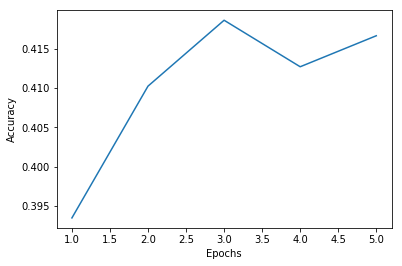

338/338 [==============================] - 9s 28ms/step
Test Accuracy: 0.2248520702123642


In [15]:
# Train the model and plot the validation error over time!
batchSize = 5
epochs = 5

x_train = np.append(x_train,x_valid,axis=0)
y_train = np.append(y_train,y_valid,axis=0)

history = model.fit(x_train, y_train,
                    batch_size=batchSize,
                    epochs=epochs,
                    verbose=1,
                    #validation_data=(x_valid,y_valid)
                    validation_split = 0.2)                    

plt.plot(range(1,epochs+1), history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Now check the test error to see how we're really doing!
score = model.evaluate(x_test, y_test)
print('Test Accuracy:', score[1])

In [16]:
# Now check the test error to see how we're really doing!
#score = model.evaluate(x_test, y_test)
#print('Test Accuracy:', score[1])

predictions = model.predict(x_test)
predictions

array([[0.20619468, 0.09285633, 0.23448552, 0.21785884, 0.06147122,
        0.18713336],
       [0.07714823, 0.25157994, 0.2836456 , 0.13090476, 0.15689316,
        0.09982823],
       [0.20846891, 0.12260985, 0.18972175, 0.17478184, 0.09493155,
        0.20948608],
       ...,
       [0.02606895, 0.19820751, 0.1387214 , 0.2761736 , 0.29307646,
        0.06775212],
       [0.04203689, 0.2878557 , 0.28331503, 0.15463984, 0.16519272,
        0.06695982],
       [0.01150115, 0.1809728 , 0.0998361 , 0.31158578, 0.35816637,
        0.03793782]], dtype=float32)

In [17]:
#Confusion Matrix
matrix = confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
print(matrix)

[[33  2  1 13  0  0]
 [ 0 12  0 26 21  0]
 [ 0 14  7  1 41  0]
 [10 12  3 24  0  2]
 [43  0  2 20  0  2]
 [ 0  1  1  0 47  0]]


In [ ]:
"""
Confusion Matrix:
Each column is a predicted director
Each row is the actual director

Matrix
[[2 0 0
  0 0 1
  1 0 2]]

Entry matrix[2,1]=1 means that we have one prediction for director 2 
where the actual director was director 1

Director Dictionary:
Coen Brothers = 0
Michael Bay = 1
Quentin Tarantino = 2
Stanley Kubrick = 3
Wes Anderson = 4
Zack Snyder = 5
"""

# BELOW IS ALL SUPPORRT STUFF - DON'T RUN!

In [ ]:
# #THIS WAS TO FIX A FILE!
# import cv2

# mov2 = np.array([])
# mov2 = mov2.reshape(0,144,256)
# mov1 = np.load('Data/color/NCfOM02_cl.npy')
# mov1 = mov1.T
# mov1 = mov1.reshape(np.shape(mov1)[0],144,256,3)
# mov1 = mov1.astype(np.float32)

# for i in range(np.shape(mov1)[0]):
#     frame = cv2.cvtColor(mov1[i,:],cv2.COLOR_BGR2GRAY)
#     frame = frame.reshape(1,144,256)
#     mov2 = np.append(mov2,frame,axis=0)

# mov2 = mov2.T
# mov2 = mov2.reshape(144*256,np.shape(mov2)[2])
# np.save('Data/blackwhite/NCfOM02_bw.npy',mov2)


Import data

In [ ]:
data_train_file = "../input/trainData2.csv"
data_test_file = "../input/testData2.csv"
train_labels_file = "../input/trainTruth2.csv"
test_labels_file = "../input/testTruth2.csv"

df_train = pd.read_csv(data_train_file)
df_test = pd.read_csv(data_test_file)
train_labels = pd.read_csv(train_labels_file)
test_labels = pd.read_csv(test_labels_file)
train_length = df_train.shape[1]
train_samples = df_train.shape[0]
test_length = df_test.shape[1]
test_samples = df_test.shape[0]



In [ ]:
train_labels.shape

In [ ]:
data_length

In [ ]:
def get_features(df):
    features = df.values/255
    return features

In [ ]:
train_features = get_features(df_train)
test_features = get_features(df_test)
train_features = train_features.reshape(144,256,3,1,train_samples)
train_features = np.transpose(train_features, (4,0,1,2,3))
test_features = test_features.reshape(144,256,3,1,test_samples)
test_features = np.transpose(test_features, (4,0,1,2,3))

In [ ]:
# example_index = 10
# plt.figure()
# _ = plt.imshow(np.reshape(train_features[example_index, :], (144, 256, 3)), 'gray')

In [ ]:
# image = train_features[0]*255
# image = image.astype(np.uint8)
# image = np.reshape(image,(144,256,3))

# plt.imshow(image)

**Convert labels to one-hot encoding**

In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

**Create the model**

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv3D(3, kernel_size=(3, 3, 1), activation='relu', input_shape=(144,256,3,1)))
model.add(tf.keras.layers.Conv3D(3, kernel_size=(3, 3, 1), activation='relu'))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.relu))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 1)))
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(3, activation = tf.nn.relu))
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

**Training Time!**

In [ ]:
EPOCHS = 3
BATCH_SIZE = 150


In [ ]:
train_features.shape

In [ ]:
train_labels.shape

In [ ]:
model.fit(train_features, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

**Testing the model**

In [ ]:
test_loss, test_acc = model.evaluate(test_features, test_labels)

In [ ]:
print('test_acc: ',test_acc)